In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
import dotenv
from tcre.env import *
from tcre.supervision import *
from tcre.exec.v1 import cli_client
session = SnorkelSession()
classes = get_candidate_classes()

In [2]:
# candidate_class = classes.inducing_cytokine
candidate_class = classes.secreted_cytokine
#candidate_class = classes.inducing_transcription_factor

task = candidate_class.field
task

'secreted_cytokine'

In [3]:
output_dir = osp.join(RESULTS_DATA_DIR, 'training-classifier', 'run1', task)
if not osp.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'/lab/data/results/training-classifier/run1/secreted_cytokine'

## Create Splits

In [4]:
cands = session.query(candidate_class.subclass).all()
len(cands)

174634

In [5]:
# DB splits -> modeling splits 
TARGET_MAP = {'train': 'train', 'dev': 'val', 'val': 'val', 'test': 'test'}

In [6]:
SPLIT_MAP

{0: 'train', 1: 'dev', 2: 'infer', 3: 'test', 4: 'val'}

In [7]:
splits = pd.DataFrame([
    dict(id=c.id, task=c.type, split=c.split)
    for c in cands
])
splits['split'] = splits['split'].map(SPLIT_MAP).map(TARGET_MAP)
splits.groupby('split').size()

split
test       100
train    48527
val        771
dtype: int64

In [8]:
splits_file = osp.join(output_dir, 'splits.json')
splits.groupby('split')['id'].unique().to_json(splits_file, orient='index')

# To limit data size for debugging:
# splits.groupby('split')['id'].unique().apply(lambda v: v[:10000]).to_json(splits_file, orient='index')
splits_file

'/lab/data/results/training-classifier/run1/secreted_cytokine/splits.json'

## Run Training

In [9]:
client = cli_client.Client(require_options=True, exceptions=['log_level', 'seed', 'vocab_limit', 'use_lower', 'save_keys'])

In [16]:
CMD_FORMAT = "{cmd} | tee {log_dir}/log.txt 2>&1"
model_dir = osp.join(output_dir, 'data')
log_dir = osp.join(output_dir, 'logs')

for d in [model_dir, log_dir]:
    if not osp.exists(d):
        os.makedirs(d)
        
cli_args = {
    'relation_class': task,
    'device': '"cuda:1"',
    'batch_size': 128,
    'output_dir': model_dir
}
train_args = {
    'splits_file': splits_file,
    'use_checkpoints': True,
    'log_iter_interval': 150,
    'log_epoch_interval': 1,
    'balance': '0',
    'dropout': '0.5',
    'wrd_embedding_type': 'w2v_trained',
    #'wrd_embedding_type': 'w2v_frozen',
    'vocab_limit': 50000,
    'use_positions': 'True',
    'use_secondary': 'False',
    'learning_rate': '0.001',
    'cell_type': 'LSTM',
#     'model_size': 'XXXL',
    'model_size': 'XXXL',
    'use_swaps': 'True',
    'bidirectional': 'False',
    'marker_list': 'doub_01',
    #'weight_decay': '0.001'
    'weight_decay': '0'
}

cmd = client.cmd(cli=cli_args, train=train_args)
cmd = CMD_FORMAT.format(cmd=cmd, log_dir=log_dir)
cmd

'python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=secreted_cytokine --device="cuda:1" --batch-size=128 --output-dir=/lab/data/results/training-classifier/run1/secreted_cytokine/data train --splits-file=/lab/data/results/training-classifier/run1/secreted_cytokine/splits.json --use-checkpoints=True --log-iter-interval=150 --log-epoch-interval=1 --balance=0 --dropout=0.5 --wrd-embedding-type=w2v_trained --vocab-limit=50000 --use-positions=True --use-secondary=False --learning-rate=0.001 --cell-type=LSTM --model-size=XXXL --use-swaps=True --bidirectional=False --marker-list=doub_01 --weight-decay=0 | tee /lab/data/results/training-classifier/run1/secreted_cytokine/logs/log.txt 2>&1'

In [ ]:
!$cmd

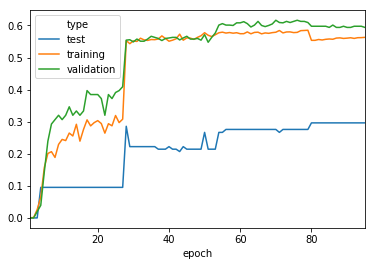

In [12]:
# Secreted cytokine
%matplotlib inline
df = pd.read_json(osp.join(model_dir, 'history.json'))
df.set_index(['epoch', 'type'])['f1'].unstack().sort_index().plot()

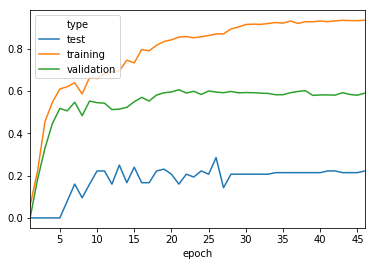

In [85]:
# Inducing cytokine
%matplotlib inline
df = pd.read_json(osp.join(model_dir, 'history.json'))
df.set_index(['epoch', 'type'])['f1'].unstack().sort_index().plot()

In [5]:
from snorkel.annotations import load_gold_labels
cids_query = get_cids_query(session, candidate_class, split=1)
L_gold_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=True, cids_query=cids_query)
L_gold_dev = np.where(L_gold_dev > 0, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev.shape

(673,)

In [6]:
train_marginals.shape, train_marginals.min(), train_marginals.max()

((6696,), 0.0016238524185457253, 0.987991787981553)

In [21]:
from snorkel.learning.pytorch import LSTM
print(candidate_class)

train_kwargs = {
    'n_epochs':        20,
    'num_layers':       1,
    'lr':              0.001,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      1,
    'seed':            1701,
    'dev_ckpt_delay':  .1
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

CandidateClass({'index': 2, 'name': 'InducingTranscriptionFactor', 'field': 'inducing_transcription_factor', 'label': 'Differentiation', 'entity_types': ['transcription_factor', 'immune_cell_type'], 'subclass': <class 'snorkel.models.candidate.InducingTranscriptionFactor'>})
[LSTM] Training model
[LSTM] n_train=6361  #epochs=20  batch size=64
[LSTM] Epoch 1 (34.35s)	Average loss=0.600154	Dev F1=32.00
[LSTM] Epoch 2 (66.40s)	Average loss=0.467063	Dev F1=39.55
[LSTM] Epoch 3 (101.09s)	Average loss=0.401534	Dev F1=37.84
[LSTM] Epoch 4 (132.22s)	Average loss=0.375169	Dev F1=52.83
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 5 (164.32s)	Average loss=0.356151	Dev F1=52.75
[LSTM] Epoch 6 (195.68s)	Average loss=0.343833	Dev F1=43.14
[LSTM] Epoch 7 (227.35s)	Average loss=0.333043	Dev F1=48.76
[LSTM] Epoch 8 (258.14s)	Average loss=0.328741	Dev F1=55.17
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 9 (289.75s)	Average loss=0.318247	Dev F1=55.92
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 10 (322.44s)	Aver

In [22]:
lstm.lstm

LSTM(100, 100, batch_first=True)

In [23]:
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.save('lstm_' + candidate_class.field, path)
path

[LSTM] Model saved as <lstm_inducing_transcription_factor>


'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/model/lstm'

## Reload for Analysis

In [24]:
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM

split = SPLIT_DEV

res_pred = {}
for c in classes:
    model = LSTM()
    path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
    model.load('lstm_' + classes[c].field, path)
    
    X = session.query(classes[c].subclass).filter(classes[c].subclass.split == split).all()
    Y = model.marginals(X)
    
    cids_query = get_cids_query(session, classes[c], split=split)
    Yg = load_gold_labels(
        session, annotator_name=classes[c].field, 
        split=split, load_as_array=True, cids_query=cids_query)
    Yg = np.where(Yg == 1, 1, -1)
    assert np.all(np.in1d(Yg, [-1, 1]))

    res_pred[c] = X, Y, Yg, model

[LSTM] Loaded model <lstm_inducing_cytokine>
[LSTM] Loaded model <lstm_secreted_cytokine>
[LSTM] Loaded model <lstm_inducing_transcription_factor>


In [26]:
res_ct = {}
for c in res_pred:
    print(c)
    X, Y, Yg, model = res_pred[c]
    # Subset to only TFs with length >= 4
    #     if c == classes.inducing_transcription_factor.name:
    #         assert len(X) == len(Yg)
    #         n = len(X)
    #         idx = [i for i in range(len(X)) if len(X[i].transcription_factor.get_span()) >= 5]
    #         X, Yg = [X[i] for i in idx], [Yg[i] for i in idx]
    #         print('Redo on TF, len before = ', n, 'len after = ', len(X))
    res_ct[c] = model.error_analysis(session, X, Yg, b=.5)

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.714
Neg. class accuracy: 0.746
Precision            0.409
Recall               0.714
F1                   0.521
----------------------------------------
TP: 95 | FP: 137 | TN: 403 | FN: 38

SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.778
Neg. class accuracy: 0.86
Precision            0.432
Recall               0.778
F1                   0.555
----------------------------------------
TP: 63 | FP: 83 | TN: 509 | FN: 18

InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.733
Neg. class accuracy: 0.812
Precision            0.508
Recall               0.733
F1                   0.6
----------------------------------------
TP: 63 | FP: 61 | TN: 263 | FN: 23



In [27]:
candidate_class = classes.inducing_transcription_factor
X, Y, Yg, model = res_pred[candidate_class.name]

In [28]:
len(X), Y.shape, Yg.shape

(410, (410,), (410,))

In [29]:
Y[:10]

array([0.08711956, 0.13915455, 0.89033943, 0.09569915, 0.11063357,
       0.93561375, 0.9499063 , 0.05103741, 0.07575299, 0.07487626],
      dtype=float32)

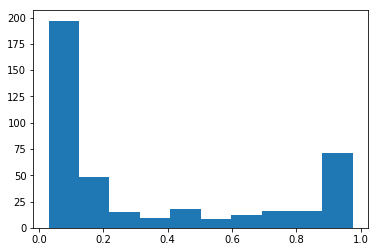

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(Y)
None

In [31]:
from snorkel import viewer
idx = np.argsort(Y)[::-1]
idx = idx[:100]
viewer.SentenceNgramViewer(
    candidates=[X[i] for i in idx], 
    session=session,
    gold=[X[i] for i in idx if Yg[i] == 1]
)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[19, 20], [42], [95]], [[71, 72], [93], [1, 68]], [[29], [50, 67], [15, 16, 17, 18,…